In [130]:
import numpy as np
import pandas as pd
import scipy.signal as signal
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

In [131]:
fs = 2000.0  
# time_duration = 3.0 # seconds
muscle_start_idx = 0  
num_muscles = 8

In [132]:
raw_emg = pd.read_csv(r"data\processed\ChipShot_Jordan_2.csv", index_col=0)
raw_emg

,Time,Rectus Femoris right,Rectus Femoris left,Hamstrings right,Hamstrings left,TibilaisÂ Anterior right,TibilaisÂ Anterior left,Gastrocnemius right,Gastrocnemius left
0,0.000000,0.085771,0.087114,0.034745,-0.040452,-0.003861,0.016953,-0.047837,-0.000168
1,0.000465,0.079057,0.093156,0.039780,-0.037934,0.010239,0.027359,-0.043809,-0.000839
2,0.000931,0.066636,0.099870,0.041123,-0.037766,0.017960,0.026688,-0.040452,-0.002182
3,0.001397,0.053544,0.104402,0.030381,-0.038437,0.026017,0.019638,-0.037095,-0.003189
4,0.001862,0.042130,0.104234,0.014603,-0.039780,0.031724,0.012924,-0.037095,-0.004196
...,...,...,...,...,...,...,...,...,...
6433,2.994672,0.019303,-0.011917,-0.028366,-0.013260,-0.012253,-0.016953,-0.004196,-0.027863
6434,2.995138,0.017960,-0.011582,-0.027359,-0.014267,-0.008896,-0.015610,-0.002350,-0.027359
6435,2.995603,0.017624,-0.012253,-0.027024,-0.012421,-0.006546,-0.016281,0.000504,-0.026352
6436,2.996069,0.019638,-0.013260,-0.027024,-0.011749,-0.005539,-0.017960,0.003693,-0.026520


In [133]:
total_samples = len(raw_emg)
t = np.linspace(0, total_samples / fs, total_samples)

In [134]:
muscle_names = [
    'Rectus Femoris right', 'Rectus Femoris left', 
    'Hamstrings right', 'Hamstrings left', 
    'TibilaisÂ Anterior right', 'TibilaisÂ Anterior left', 
    'Gastrocnemius right', 'Gastrocnemius left'
]

processed_data_storage = {'Time': t}

In [135]:
def process_emg(raw_signal, fs):
    # Safety Flatten
    raw_signal = np.asarray(raw_signal).flatten()
    # Filter
    sos_bp = signal.butter(4, [20, 450], btype='bandpass', fs=fs, output='sos')
    emg_bandpassed = signal.sosfiltfilt(sos_bp, raw_signal)
    b_notch, a_notch = signal.iirnotch(w0=50.0, Q=30.0, fs=fs)
    emg_cleaned = signal.filtfilt(b_notch, a_notch, emg_bandpassed)
    emg_rectified = np.abs(emg_cleaned)
    # Envelope
    window_ms = 50 
    window_samples = int((window_ms / 1000) * fs)
    emg_envelope = pd.Series(emg_rectified).rolling(window=window_samples, center=True, min_periods=1).apply(lambda x: np.sqrt(np.mean(x**2)))
    return emg_envelope.values

Processing 8 muscles...


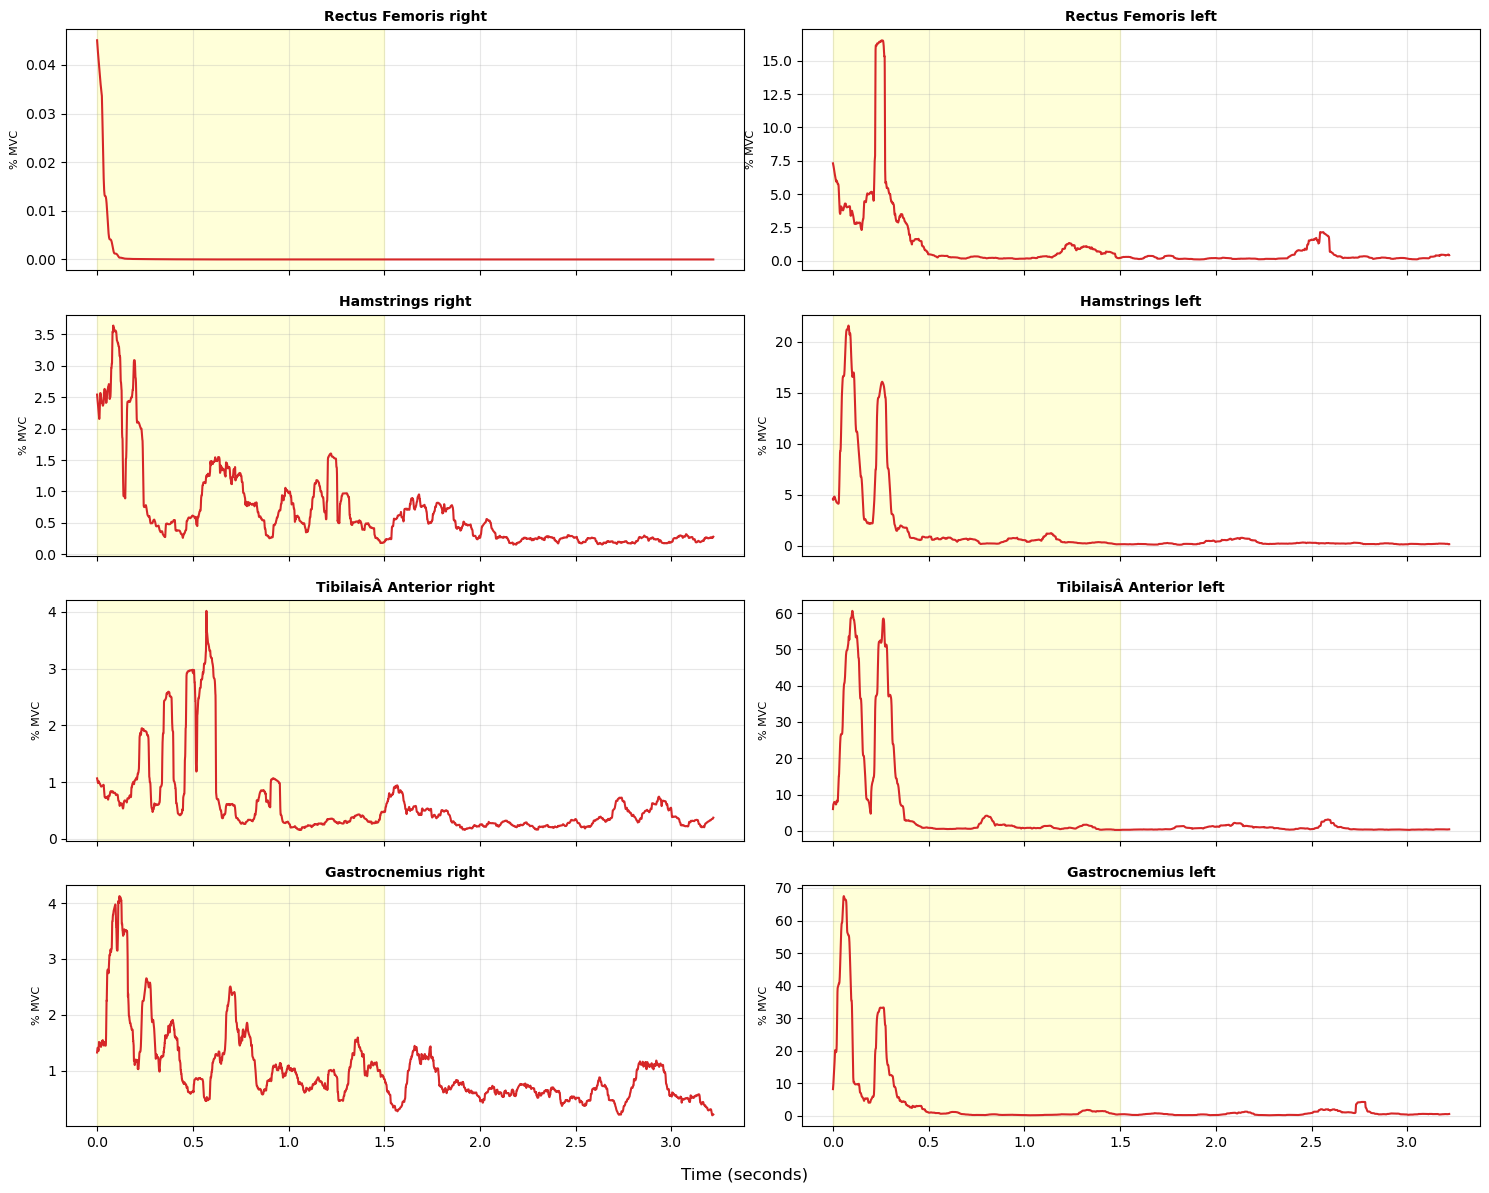

In [136]:
print(f"Processing {num_muscles} muscles...")
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
axes = axes.flatten()
for i in range(num_muscles):
    col_idx = muscle_start_idx + i
    
    # 1. Get Data
    if col_idx >= raw_emg.shape[1]: break
    raw_data = raw_emg.iloc[:, col_idx].values
    
    # 2. Process
    envelope = process_emg(raw_data, fs)
    
    # 3. Normalize (Placeholder MVC = 1.0)
    mvc_value = 1.0 
    norm_envelope = (envelope / mvc_value) * 100
    
    # 4. STORE DATA
    # We add the new column to the existing dictionary
    current_muscle_name = muscle_names[i]
    processed_data_storage[current_muscle_name] = norm_envelope
    ax = axes[i]
    ax.plot(t, norm_envelope, color='#d62728', linewidth=1.5)
    ax.set_title(current_muscle_name, fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('% MVC', fontsize=8)
    ax.axvspan(0.0, 1.5, color='yellow', alpha=0.15) # Updated to your 0-1.5s window

fig.supxlabel('Time (seconds)', fontsize=12)
plt.tight_layout()
plt.show()

In [137]:
df_processed = pd.DataFrame(processed_data_storage)

# Save
filename = "processed_emg_shot1_fixed.csv"
df_processed.to_csv(filename, index=False)

# Verify - This should now print ALL muscle names
print("Columns in DataFrame:", df_processed.columns.tolist())
display(df_processed)

Columns in DataFrame: ['Time', 'Rectus Femoris right', 'Rectus Femoris left', 'Hamstrings right', 'Hamstrings left', 'TibilaisÂ\xa0Anterior right', 'TibilaisÂ\xa0Anterior left', 'Gastrocnemius right', 'Gastrocnemius left']


,Time,Rectus Femoris right,Rectus Femoris left,Hamstrings right,Hamstrings left,TibilaisÂ Anterior right,TibilaisÂ Anterior left,Gastrocnemius right,Gastrocnemius left
0,0.0000,0.045060,7.302494,2.541118,4.542920,1.065374,6.001678,1.328692,8.200947
1,0.0005,0.044746,7.268981,2.522985,4.501328,1.058173,6.418575,1.341203,8.503014
2,0.0010,0.044447,7.240505,2.502675,4.492335,1.049976,6.834038,1.355658,8.858263
3,0.0015,0.044160,7.213033,2.481029,4.533540,1.040947,7.103078,1.374347,9.268817
4,0.0020,0.043883,7.180867,2.458715,4.603428,1.031487,7.245485,1.393840,9.727918
...,...,...,...,...,...,...,...,...,...
6433,3.2170,0.000003,0.408867,0.271021,0.159496,0.359037,0.415222,0.213711,0.558108
6434,3.2175,0.000003,0.402882,0.273367,0.160490,0.362346,0.418397,0.215267,0.560977
6435,3.2180,0.000002,0.400665,0.275638,0.161282,0.365744,0.420788,0.216887,0.563685
6436,3.2185,0.000002,0.402394,0.278107,0.162034,0.369224,0.424304,0.218458,0.568361


In [138]:
print(df_processed.columns.tolist())

['Time', 'Rectus Femoris right', 'Rectus Femoris left', 'Hamstrings right', 'Hamstrings left', 'TibilaisÂ\xa0Anterior right', 'TibilaisÂ\xa0Anterior left', 'Gastrocnemius right', 'Gastrocnemius left']


In [139]:
def extract_features_from_shot(df, fs=2000.0):
    """
    Input: DataFrame containing 'Time' and Muscle Columns.
    Output: A single row (Pandas DataFrame) with features for all muscles.
    """
    
    # Dictionary to hold the results for this specific shot
    features = {}
    
    # Get the Time column for timing calculations
    time_col = df['Time'].values
    
    # Identify Muscle Columns (All columns except 'Time')
    muscle_cols = [col for col in df.columns if col != 'Time']
    
    for muscle in muscle_cols:
        # Get the envelope data for this muscle
        envelope = df[muscle].values
        
        # --- A. Peak Amplitude (Max Activation) ---
        peak_amp = np.max(envelope)
        
        # --- B. Mean Amplitude (Average Effort) ---
        mean_amp = np.mean(envelope)
        
        # --- C. Time to Peak (Synchronization) ---
        # Find index of max value, get corresponding Time value
        peak_idx = np.argmax(envelope)
        time_to_peak = time_col[peak_idx]
        
        # --- D. Integrated EMG (Total Effort/Energy) ---
        # Area under the curve
        iemg = trapezoid(envelope, dx=1/fs)
        
        # --- E. Impact Phase Activity (0.0s to 1.5s) ---
        # Specific for your "Ideal Model" checks
        # Find index closest to 1.5 seconds
        end_index = int(1.5 * fs)
        if end_index > len(envelope): end_index = len(envelope)
        
        impact_mean = np.mean(envelope[0:end_index])
        
        # STORE FEATURES
        # Key format: "MuscleName_Feature"
        features[f"{muscle}_Max"] = peak_amp
        features[f"{muscle}_Mean"] = mean_amp
        features[f"{muscle}_TimePeak"] = time_to_peak
        features[f"{muscle}_iEMG"] = iemg
        features[f"{muscle}_ImpactMean"] = impact_mean

    # Convert dictionary to DataFrame (1 row)
    return pd.DataFrame([features])

In [143]:
df_features = extract_features_from_shot(df_processed, fs=fs)

In [144]:
print(f"Extraction Complete!")
print(f"Total Features Extracted: {df_features.shape[1]}")

# Display the first few columns to verify
display(df_features) 

# Save Features to a separate CSV
feature_filename = "features_shot1.csv"
df_features.to_csv(feature_filename, index=False)
print(f"Features saved to '{feature_filename}'")

Extraction Complete!
Total Features Extracted: 40


,Rectus Femoris right_Max,Rectus Femoris right_Mean,Rectus Femoris right_TimePeak,Rectus Femoris right_iEMG,Rectus Femoris right_ImpactMean,Rectus Femoris left_Max,Rectus Femoris left_Mean,Rectus Femoris left_TimePeak,Rectus Femoris left_iEMG,Rectus Femoris left_ImpactMean,...,Gastrocnemius right_Max,Gastrocnemius right_Mean,Gastrocnemius right_TimePeak,Gastrocnemius right_iEMG,Gastrocnemius right_ImpactMean,Gastrocnemius left_Max,Gastrocnemius left_Mean,Gastrocnemius left_TimePeak,Gastrocnemius left_iEMG,Gastrocnemius left_ImpactMean
0,0.04506,0.00052,0.0,0.001664,0.001114,16.533568,1.051245,0.254039,3.382032,1.869598,...,4.122739,0.994982,0.117018,3.20246,1.355268,67.489306,3.192545,0.056509,10.27461,6.00776


Features saved to 'features_shot1.csv'
